In [2]:
from PIL import Image
import torch
import cv2
import numpy as np
import dask.array as da
from romatch import roma_outdoor
from romatch.models.matcher import RegressionMatcher
import omnialigner as om
import torch.nn.functional as F
from omnialigner.omni_3D import Omni3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

finest_scale = 1
hs, ws = 1024, 1024
Tensor_image_NCHW = torch.FloatTensor
plt = om.pl.plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# om_data = Omni3D(config_info="/cluster/home/bqhu_jh/projects/omni/config/fair/config_liver.yaml")
om_data = Omni3D(config_info="/cluster/home/bqhu_jh/projects/omni/config/panlab/config_pdac.yaml")
overwrite_cache = False

INFO:omni_aligner:config.datasets: project: panlab
INFO:omni_aligner:config.datasets: group: pdac
INFO:omni_aligner:config.datasets: version: v6
INFO:omni_aligner:config.datasets: nonrigid: False
INFO:omni_aligner:config.datasets: zoom_level: 3
INFO:omni_aligner:config.datasets: root_dir: ~/projects/scGaussian3dGen/
INFO:omni_aligner:config.datasets: tag: raw
INFO:omni_aligner:config.datasets: method: gigapath
INFO:omni_aligner:config.datasets: transform_engine: torch
INFO:omni_aligner:config.datasets: raw_img_prefix: .qptiff
INFO:omni_aligner:config.datasets: max_size: 1280
INFO:omni_aligner:config.datasets: l_scales: [40, 10, 5, 1]
INFO:omni_aligner:config.datasets: file_data: ~/projects/omni/config/panlab/data_panlab.csv
INFO:omni_aligner:config.datasets: file_IHC_name: ~/projects/omni/config/panlab/IHC_layer_info.json
INFO:omni_aligner:config.datasets: plt_row_col: [30, 30]
INFO:omni_aligner:config.datasets: plt_figsize: [30, 30]
INFO:omni_aligner:config.datasets: to_gray: {'alpha_

In [5]:
tensor_image_NCHW = om_data.load_3d_NCHW("AFFINE")
tensor_image_NCHW.shape

INFO:omni_aligner:loading /cluster/home/bqhu_jh/projects/scGaussian3dGen//analysis/panlab/v6/05.align3d/pdac//affine_tensor.pt


torch.Size([822, 1, 1280, 1280])

In [7]:
from omnialigner.keypoints.roma_dense import RomaDenseDetector

idx = 3
kwargs = {
    "device": torch.device('cuda'),
    "upsample_res": (tensor_image_NCHW.shape[2], tensor_image_NCHW.shape[3])
}

roma_dense = RomaDenseDetector(**kwargs)


Using coarse resolution (560, 560), and upsample res (1280, 1280)


In [8]:
for idx in range(1, 2):
    kpts1, kpts2, index_matches, corresps = roma_dense.match(tensor_image_NCHW[idx:idx+1], tensor_image_NCHW[idx+1:idx+2])
    kd = om.kp.KeypointPairs(
        image_F=tensor_image_NCHW[idx:idx+1],
        image_M=tensor_image_NCHW[idx+1:idx+2],
        mkpts_F=kpts1.detach().cpu(),
        mkpts_M=kpts2.detach().cpu(),
        index_matches=index_matches
    )
    fig = kd.plot_dataset()
    fig.savefig(f"roma_matches_pdac_{idx}.png")
    break

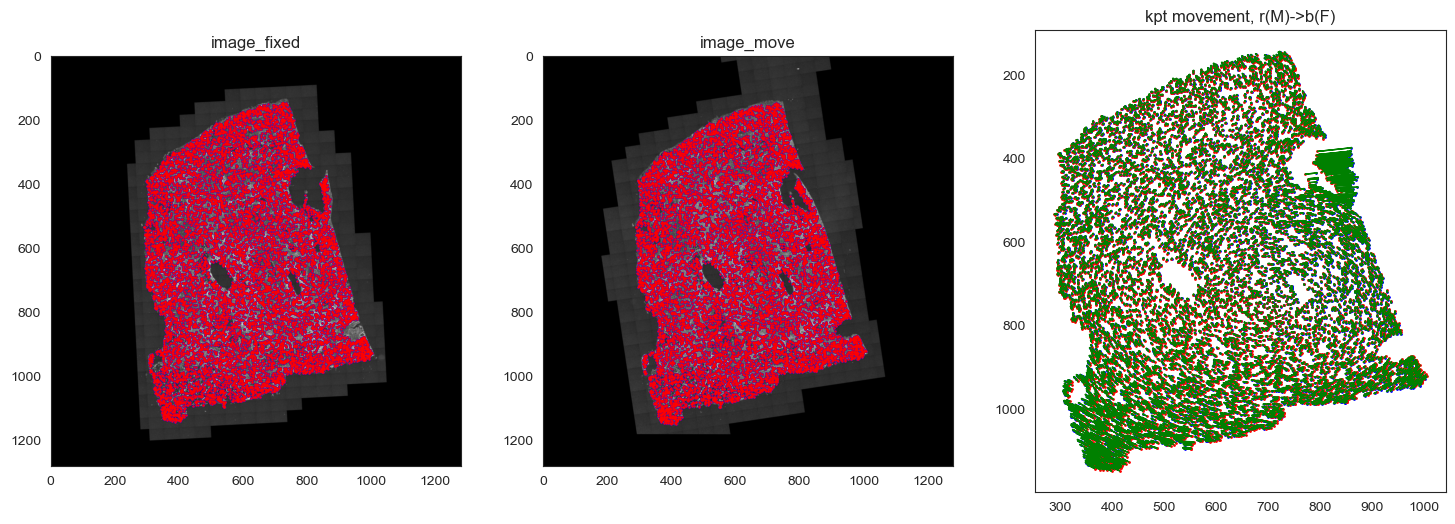

In [9]:
fig

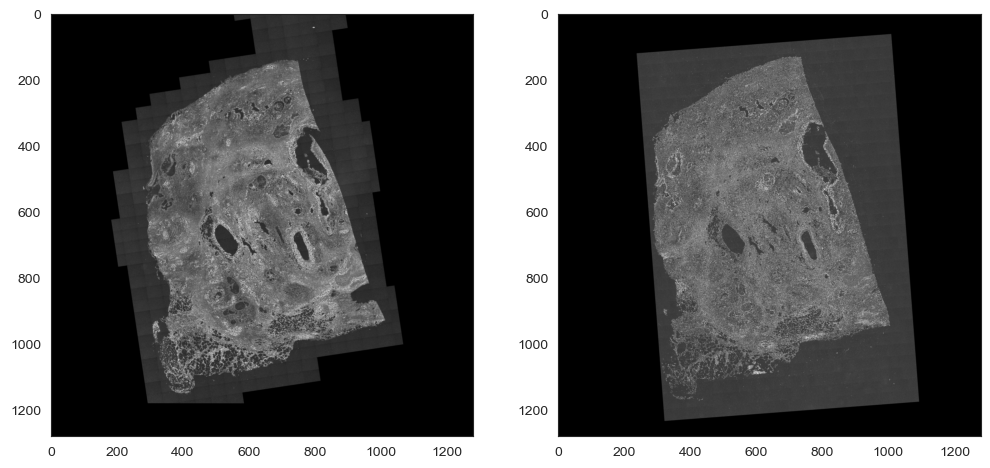

In [14]:
idx = 2
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(om.tl.tensor2im(tensor_image_NCHW[idx:idx+1]))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(om.tl.tensor2im(tensor_image_NCHW[idx+1:idx+2]))



In [31]:


def warp_symmetric(roma_model: RegressionMatcher, x1: Tensor_image_NCHW, x2: Tensor_image_NCHW):
    batch = {"im_A": x1, "im_B": x2}
    corresps = roma_model.forward_symmetric(batch)
    flow_raw = corresps[finest_scale]["flow"]
    flow_A_to_im_B = F.interpolate(
        flow_raw, size=(hs, ws), align_corners=False, mode="bilinear"
    )
    grid_AB_to_BA = flow_A_to_im_B.permute(0, 2, 3, 1)
    out_img_BA = F.grid_sample(
        input=torch.cat([batch["im_B"], batch["im_A"]], dim=0),
        grid=grid_AB_to_BA,
        mode="bilinear",
        align_corners=False)
    return out_img_BA, grid_AB_to_BA

def viz_roma(raw_im1, raw_im2, out_img_BA) -> plt.Figure:
    fig = plt.figure(figsize=(12, 16))
    ax = fig.add_subplot(3, 2, 1)
    ax.imshow(raw_im1)
    ax.set_title("raw_A")
    ax.set_axis_off()

    ax = fig.add_subplot(3, 2, 2)
    ax.imshow(raw_im2)
    ax.set_title("raw_B")
    ax.set_axis_off()

    ax = fig.add_subplot(3, 2, 3)
    ax.imshow(om.tl.tensor2im(out_img_BA[0:1]))
    ax.set_title("B_to_A")
    ax.set_axis_off()

    ax = fig.add_subplot(3, 2, 4)
    ax.imshow(om.tl.tensor2im(out_img_BA[1:2]))
    ax.set_title("A_to_B")
    ax.set_axis_off()

    ovlp_img_1 = raw_im1.copy()
    ovlp_img_1[:, :, 2] = 255 - ovlp_img_1[:, :, 0]
    ovlp_img_1[:, :, 1] = 0
    ovlp_img_1[:, :, 0] = 255-om.tl.tensor2im(out_img_BA[0:1])[:, :, 2]
    ax = fig.add_subplot(3, 2, 5)
    ax.imshow(ovlp_img_1)
    ax.set_title("B_to_A")
    ax.set_axis_off()

    ovlp_img_2 = raw_im2.copy()
    ovlp_img_2[:, :, 2] = 255 - ovlp_img_2[:, :, 0]
    ovlp_img_2[:, :, 1] = 0
    ovlp_img_2[:, :, 0] = 255-om.tl.tensor2im(out_img_BA[1:2])[:, :, 2]
    ax = fig.add_subplot(3, 2, 6)
    ax.imshow(ovlp_img_2)
    ax.set_title("A_to_B")
    ax.set_axis_off()

    
    return fig
    
def match_roma(raw_im1, raw_im2) -> plt.Figure:
    device = torch.device('cpu')
    size_coarse = 560

    roma_model = roma_outdoor(device=device, coarse_res=size_coarse, upsample_res=(raw_im1.shape[0], raw_im1.shape[1]))
    # roma_model_tiny = tiny_roma_v1_outdoor(device=device)
    H, W = roma_model.get_output_resolution()
    x1 = om.tl.im2tensor(cv2.resize(raw_im1, (roma_model.w_resized, roma_model.h_resized)))
    x2 = om.tl.im2tensor(cv2.resize(raw_im2, (roma_model.w_resized, roma_model.h_resized)))
    x1 = x1.to(device)
    x2 = x2.to(device)
    out_img_BA, grid_AB_to_BA = warp_symmetric(roma_model=roma_model, x1=x1, x2=x2)
    fig = viz_roma(raw_im1, raw_im2, out_img_BA)
    return fig, grid_AB_to_BA

In [52]:
roma_model.w_resized

560

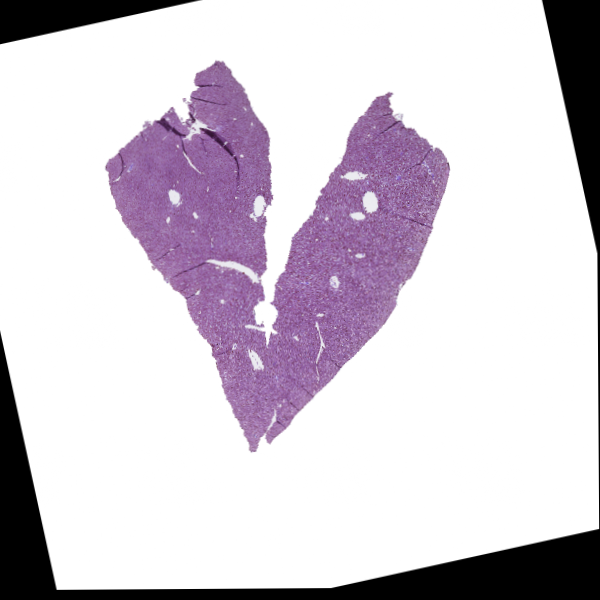

In [12]:
idx = 3
raw_im1 = Image.fromarray(om.tl.tensor2im(tensor_image_NCHW[idx+0:idx+1]))
raw_im2 = Image.fromarray(om.tl.tensor2im(tensor_image_NCHW[idx+1:idx+2]))
raw_im2

In [56]:
roma_model.h_resized

560

In [58]:
roma_dense.roma.h_resized

560

In [13]:
device = torch.device('cuda')
size_coarse = 560
roma_model = roma_outdoor(device=device, coarse_res=size_coarse, upsample_res=(raw_im1.size[0], raw_im1.size[1]))
# roma_model_tiny = tiny_roma_v1_outdoor(device=device)
H, W = roma_model.get_output_resolution()

Using coarse resolution (560, 560), and upsample res (600, 600)


In [20]:
W_A, H_A = raw_im1.size
W_B, H_B = raw_im2.size


warp, certainty, corresps = roma_model.match(raw_im1, raw_im2, device=device)

matches, certainty = roma_model.sample(warp, certainty, num=5000)
kpts1, kpts2 = roma_model.to_pixel_coordinates(matches, H_A, W_A, H_B, W_B)    

In [48]:
H_A

600

In [44]:
roma_model.upsample_preds

True

In [43]:
roma_model.encoder.dinov2_vitl14

[DinoVisionTransformer(
   (patch_embed): PatchEmbed(
     (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
     (norm): Identity()
   )
   (blocks): ModuleList(
     (0-23): 24 x NestedTensorBlock(
       (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       (attn): MemEffAttention(
         (qkv): Linear(in_features=1024, out_features=3072, bias=True)
         (attn_drop): Dropout(p=0.0, inplace=False)
         (proj): Linear(in_features=1024, out_features=1024, bias=True)
         (proj_drop): Dropout(p=0.0, inplace=False)
       )
       (ls1): LayerScale()
       (drop_path1): Identity()
       (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       (mlp): Mlp(
         (fc1): Linear(in_features=1024, out_features=4096, bias=True)
         (act): GELU(approximate='none')
         (fc2): Linear(in_features=4096, out_features=1024, bias=True)
         (drop): Dropout(p=0.0, inplace=False)
       )
       (ls2): LayerScale()
       (drop_

In [41]:
roma_model.decoder

Decoder(
  (embedding_decoder): TransformerDecoder(
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): Identity()
        (drop_path2): Identity()
      )
      (1): Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwis

In [39]:
roma_model.decoder.proj

ModuleDict(
  (16): Sequential(
    (0): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (8): Sequential(
    (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [38]:
roma_model.decoder

Decoder(
  (embedding_decoder): TransformerDecoder(
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): Identity()
        (drop_path2): Identity()
      )
      (1): Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwis

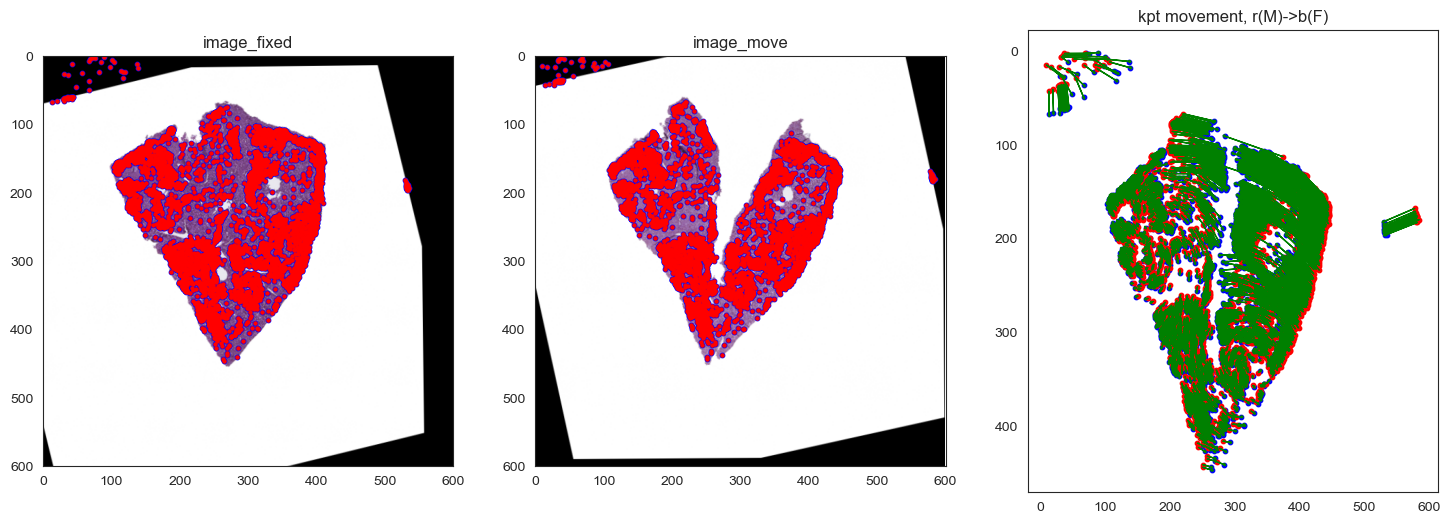

In [18]:

from omnialigner.plotting.keypoint_viz import plot_kg_dataset

kd = om.kp.KeypointPairs(
    image_F=om.tl.im2tensor(np.array(raw_im1)),
    image_M=om.tl.im2tensor(np.array(raw_im2)),
    mkpts_F=kpts1.detach().cpu(),
    mkpts_M=kpts2.detach().cpu(),
    index_matches=range(len(kpts1))
)

kd.plot_dataset()

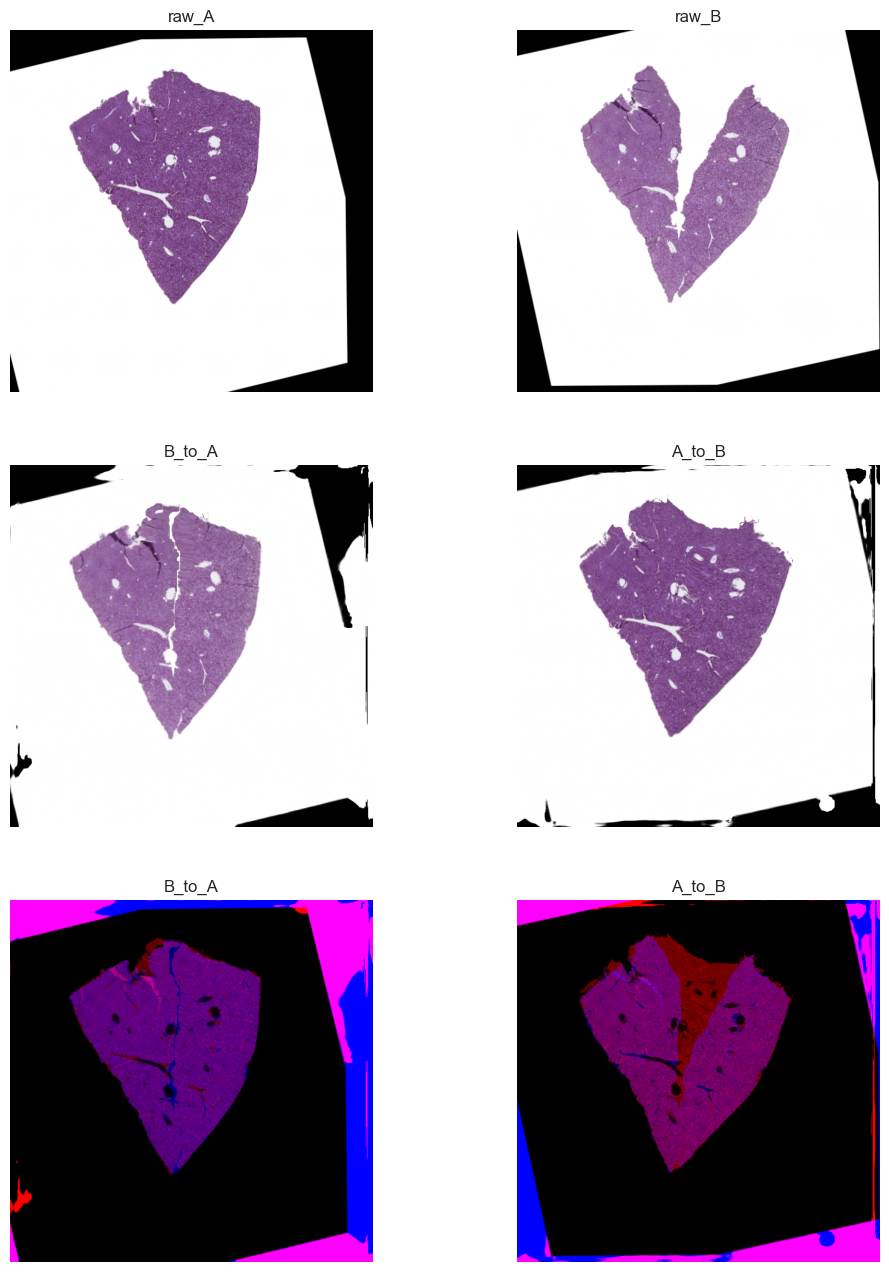

In [32]:
finest_scale = 1
hs, ws = 600, 600
def warp_symmetric(corresps, x1: Tensor_image_NCHW, x2: Tensor_image_NCHW):
    batch = {"im_A": x1, "im_B": x2}
    flow_raw = corresps[finest_scale]["flow"]
    flow_A_to_im_B = F.interpolate(
        flow_raw, size=(hs, ws), align_corners=False, mode="bilinear"
    )
    grid_AB_to_BA = flow_A_to_im_B.permute(0, 2, 3, 1)
    out_img_BA = F.grid_sample(
        input=torch.cat([batch["im_B"].cpu(), batch["im_A"].cpu()], dim=0),
        grid=grid_AB_to_BA.cpu(),
        mode="bilinear",
        align_corners=False)
    return out_img_BA, grid_AB_to_BA

out_img_BA, grid_AB_to_BA = warp_symmetric(corresps=corresps, x1=om.tl.im2tensor(np.array(raw_im1)), x2=om.tl.im2tensor(np.array(raw_im2)))
fig = viz_roma(np.array(raw_im1), np.array(raw_im2), out_img_BA)



In [28]:
out_img_BA

torch.Size([2, 3, 600, 600])